2.1 데이터 정리

먼저 데이터를 로드하고 결측값을 처리하며 필요 없는 열을 제거합니다.

결측치 처리 전과 후 데이터 수를 비교하여 결측지가 1개 있었음을 확인.

In [1]:
import pandas as pd # 데이터프레임 라이브러리
import numpy as np

# 데이터 로드
file_path = './wine_review.csv'
wine_data = pd.read_csv(file_path)

initial_review_count = wine_data.shape[0]

# 리뷰열에서 결측값 처리
wine_data = wine_data.dropna(subset=['reviews.text'])

# 전처리 작업 후 리뷰 데이터의 수
processed_review_count = wine_data.shape[0]

print(f"처리 이전 리뷰 데이터 수: {initial_review_count}건")
print(f"처리 이후 리뷰 데이터 수: {processed_review_count}건")

처리 이전 리뷰 데이터 수: 2890건
처리 이후 리뷰 데이터 수: 2889건


In [17]:
# 평점 빈도수 계산
rating_counts = wine_data['reviews.rating'].value_counts().sort_index()

# 빈도수 출력
print("평점 빈도수:")
print(rating_counts)

평점 빈도수:
reviews.rating
1.0      69
2.0      43
3.0      65
4.0     221
5.0    2046
Name: count, dtype: int64


2.2 텍스트 토큰화 및 불용어 제거

NLTK 라이브러리를 사용하여 텍스트 데이터를 토큰화

분석에 방해가 되는 노이즈(불용어, 특수 문자, 숫자)를 제거

In [11]:
%pip install nltk 
import re # 정규 표현식 라이브러리
import nltk # 자연어 처리 라이브러리
from nltk.corpus import stopwords # 불용어 리스트 제공 모듈
from nltk.tokenize import word_tokenize # 단어 토큰화 모듈
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold  # 데이터 분할 및 교차 검증 모듈
from nltk.stem import PorterStemmer # 스테밍 모듈
nltk.download('vader_lexicon')  # VADER 감정 분석기에 필요한 어휘 자료
nltk.download('punkt') # 토큰화를 위한 데이터
nltk.download('stopwords') # 불용어 리스트

stop_words = set(stopwords.words('english'))

# PorterStemmer 초기화
stemmer = PorterStemmer()

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)
    # 숫자 제거
    text = re.sub(r'\d', ' ', text)
    # 단어 토큰화
    tokens = word_tokenize(text)
    # 불용어 제거 및 알파벳 문자인 단어만 남기기
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # 각 토큰을 스테밍하여 어간 추출
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # 스테밍된 토큰들을 공백으로 결합하여 반환
    return ' '.join(stemmed_tokens)

# 리뷰 텍스트에 전처리 함수 적용
wine_data['processed_text'] = wine_data['reviews.text'].apply(preprocess_text)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# 전처리 전후의 단어 수 비교 함수
def compare_word_counts(row):
    original_text = row['reviews.text']
    processed_text = row['processed_text']
    
    original_word_count = len(word_tokenize(original_text))
    processed_word_count = len(word_tokenize(processed_text))
    
    return original_word_count, processed_word_count

# 샘플 데이터에 적용하여 결과 확인
sample_data = wine_data.head(10).apply(compare_word_counts, axis=1)
sample_data = pd.DataFrame(sample_data.tolist(), columns=['original_word_count', 'processed_word_count'])

print(sample_data)

# 전체 데이터셋에 대한 평균 단어 수 비교
average_original_word_count = wine_data['reviews.text'].apply(lambda x: len(word_tokenize(x))).mean()
average_processed_word_count = wine_data['processed_text'].apply(lambda x: len(word_tokenize(x))).mean()

print(f"처리 이전 평균 단어 수: {average_original_word_count:.2f}")
print(f"처리 이후 평균 단어 수: {average_processed_word_count:.2f}")

   original_word_count  processed_word_count
0                    9                     4
1                   10                     4
2                   29                    10
3                   11                     5
4                   76                    29
5                   47                    19
6                   26                    11
7                   82                    35
8                    4                     2
9                   28                    14
처리 이전 평균 단어 수: 39.13
처리 이후 평균 단어 수: 17.29


2.3 텍스트 정규화 (스테밍 또는 표제어 추출)

NLTK의 PorterStemmer를 사용하여 텍스트를 정규화

In [13]:
# 샘플 결과 확인
print(wine_data[['reviews.text', 'processed_text']].head())

                                        reviews.text  \
0      This a fantastic white wine for any occasion!   
1   Tart, not sweet...very refreshing and delicious!   
2  I was given this wine so it was a delightful s...   
3  This is a phenomenal wine and my new favorite ...   
4  4 750ml bottles for the price of two With way ...   

                                      processed_text  
0                           fantast white wine occas  
1                          tart sweet refresh delici  
2  given wine delight surpris find flavor delici ...  
3                      phenomen wine new favorit red  
4  ml bottl price two way less packag ye pleas ne...  


3. 모델 선택 및 학습

3.1 모델 선택

로지스틱 회귀 분석을 수행한다. 평가 지표는 rating(평점) 열을 사용하는 방법과 VADER 를 사용하는 방법으로 나누어 진행한다.

In [14]:
import matplotlib.pyplot as plt # 시각화 라이브러리
import seaborn as sns # 시각화 라이브러리
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF 벡터화 모듈
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모듈
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc # 모델 평가 모듈
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV #그리드서치 모듈

평점을 기준으로 한 감성분석

교차 검증 정확도: [0.79265659 0.79437229 0.82900433 0.85281385 0.83549784]
교차 검증 정확도 평균: 0.8208689798322627
평점을 기준으로 한 감성 분석 (기본 모델)
Classification Report (Basic):
               precision    recall  f1-score   support

           0       0.71      0.15      0.25       114
           1       0.82      0.98      0.90       464

    accuracy                           0.82       578
   macro avg       0.77      0.57      0.57       578
weighted avg       0.80      0.82      0.77       578

Confusion Matrix (Basic):
 [[ 17  97]
 [  7 457]]
ROC-AUC (Basic): 0.8223306110102844
Best Hyperparameters (Based on Rating): {'C': 1, 'solver': 'liblinear'}
평점을 기준으로 한 감성 분석 (튜닝된 모델)
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.71      0.15      0.25       114
           1       0.82      0.98      0.90       464

    accuracy                           0.82       578
   macro avg       0.77      0.57      0.57       578
weighted avg       0.80    

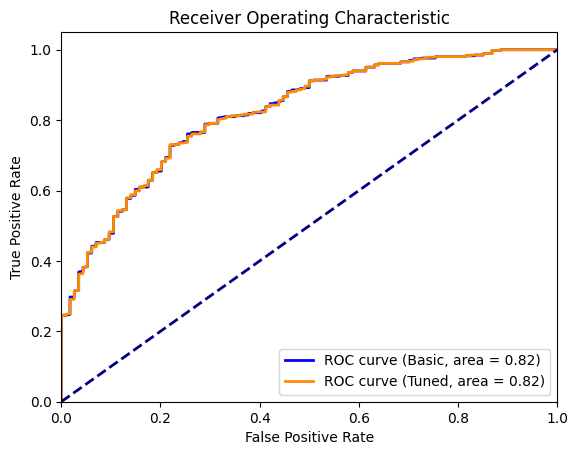

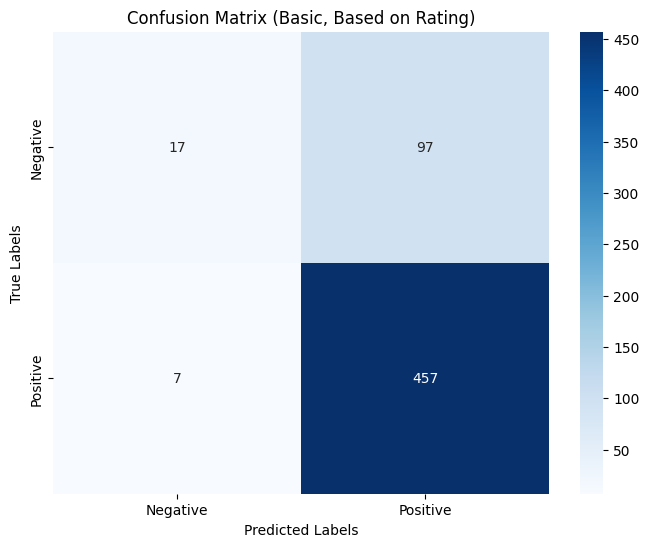

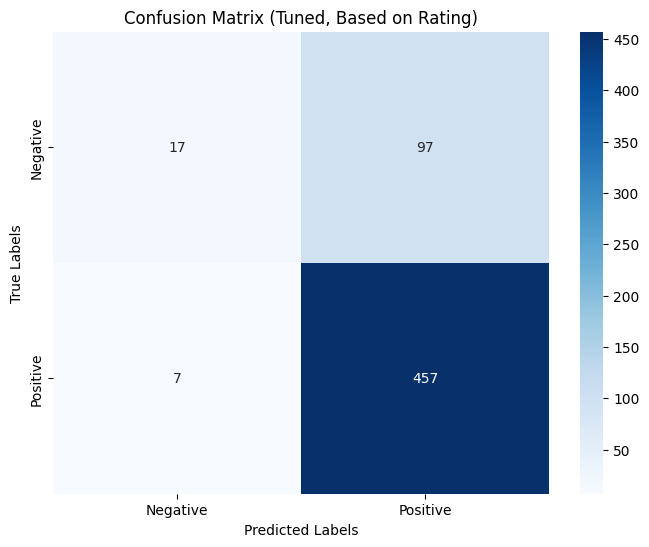

In [15]:
# 전처리된 데이터 사용 (이미 전처리된 텍스트를 사용)
# 감성 레이블 생성 (임의로 긍정/부정 레이블 부여, 실제 데이터에 맞게 수정)
# 이 예제에서는 3 이상의 평점은 긍정, 그 미만은 부정으로 간주
wine_data['sentiment'] = wine_data['reviews.rating'].apply(lambda x: 1 if x >= 3 else 0)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(wine_data['processed_text'], wine_data['sentiment'], test_size=0.2, random_state=42)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 기본 로지스틱 회귀 모델 학습
model = LogisticRegression()

# 교차 검증을 통한 모델 평가
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring='accuracy')
print(f'교차 검증 정확도: {cross_val_scores}')
print(f'교차 검증 정확도 평균: {cross_val_scores.mean()}')

# 전체 학습 데이터로 모델 학습
model.fit(X_train_tfidf, y_train)

# 기본 모델 성능 평가
y_pred_basic = model.predict(X_test_tfidf)
y_pred_prob_basic = model.predict_proba(X_test_tfidf)[:, 1]

print("평점을 기준으로 한 감성 분석 (기본 모델)")
print("Classification Report (Basic):\n", classification_report(y_test, y_pred_basic))
print("Confusion Matrix (Basic):\n", confusion_matrix(y_test, y_pred_basic))

roc_auc_basic = roc_auc_score(y_test, y_pred_prob_basic)
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_pred_prob_basic)
print("ROC-AUC (Basic):", roc_auc_basic)

# 그리드 서치를 이용한 로지스틱 회귀 모델 학습
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters (Based on Rating):", grid.best_params_)

# 최적 모델로 예측
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test_tfidf)
y_pred_prob_tuned = best_model.predict_proba(X_test_tfidf)[:, 1]

# 튜닝된 모델 성능 평가
print("평점을 기준으로 한 감성 분석 (튜닝된 모델)")
print("Classification Report (Tuned):\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))

roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_prob_tuned)
print("ROC-AUC (Tuned):", roc_auc_tuned)

# ROC 곡선 그리기 (기본 모델 vs 튜닝된 모델)
plt.figure()
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'ROC curve (Basic, area = {roc_auc_basic:.2f})')
plt.plot(fpr_tuned, tpr_tuned, color='darkorange', lw=2, label=f'ROC curve (Tuned, area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 혼동 행렬 시각화 함수 정의
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# 혼동 행렬 시각화 (기본 모델)
plot_confusion_matrix(y_test, y_pred_basic, title='Confusion Matrix (Basic, Based on Rating)')

# 혼동 행렬 시각화 (튜닝된 모델)
plot_confusion_matrix(y_test, y_pred_tuned, title='Confusion Matrix (Tuned, Based on Rating)')

VADER를 기준으로 한 감성 분석

교차 검증 정확도: [0.92142857 0.90714286 0.9047619  0.91190476 0.88809524]
교차 검증 정확도 평균: 0.9066666666666666
VADER를 기준으로 한 감성 분석 (기본 모델)
Classification Report (Basic):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.88      1.00      0.94       463

    accuracy                           0.88       526
   macro avg       0.44      0.50      0.47       526
weighted avg       0.77      0.88      0.82       526

Confusion Matrix (Basic):
 [[  0  63]
 [  0 463]]
ROC-AUC (Basic): 0.8739415132503685
Best Hyperparameters (Based on VADER): {'C': 10, 'solver': 'liblinear'}
VADER를 기준으로 한 감성 분석 (튜닝된 모델)
Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.95      0.32      0.48        63
           1       0.91      1.00      0.95       463

    accuracy                           0.92       526
   macro avg       0.93      0.66      0.72       526
weighted avg       0.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


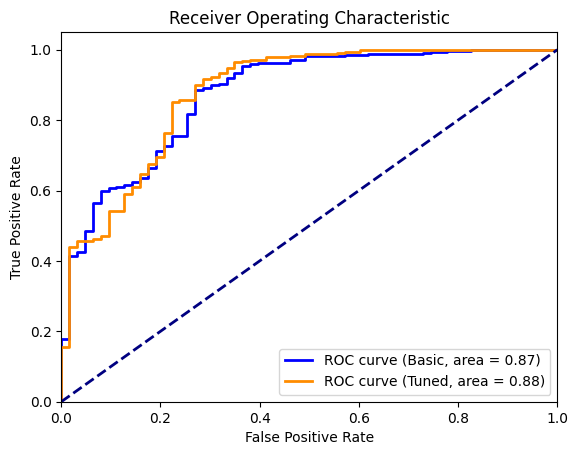

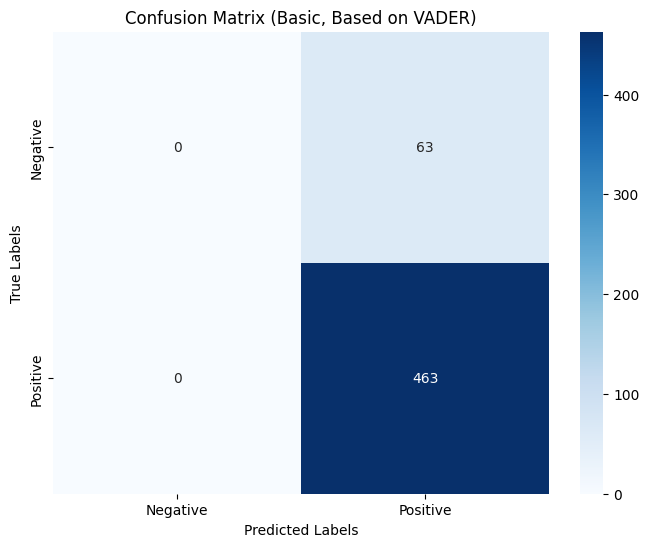

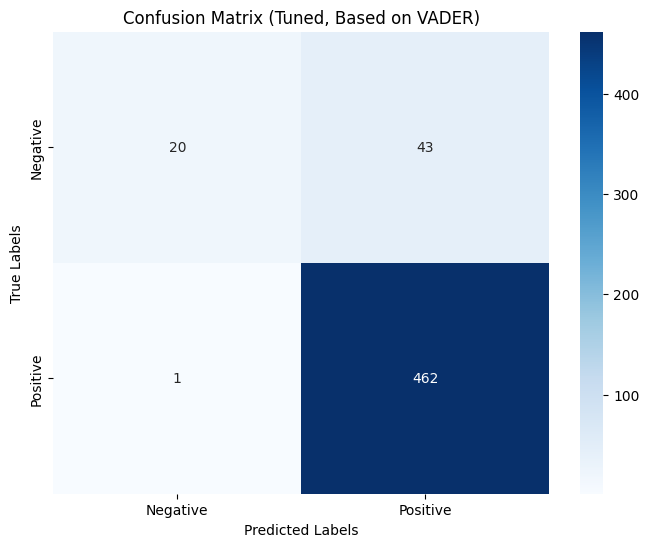

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# VADER 초기화
sia = SentimentIntensityAnalyzer()

# VADER 감성 분석 함수 정의
def vader_sentiment(text):
    score = sia.polarity_scores(text)
    # Compound score가 0.05 이상이면 긍정, -0.05 이하이면 부정, 그 외는 중립
    if score['compound'] >= 0.05:
        return 1  # 긍정
    elif score['compound'] <= -0.05:
        return 0  # 부정
    else:
        return 2  # 중립
    
    # VADER를 기준으로 한 감성 레이블 생성
wine_data['sentiment_by_vader'] = wine_data['reviews.text'].apply(vader_sentiment)

# 중립 리뷰 제거 (0 또는 1의 감성 레이블만 사용)
wine_data_vader = wine_data[wine_data['sentiment_by_vader'] != 2]

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(wine_data_vader['processed_text'], wine_data_vader['sentiment_by_vader'], test_size=0.2, random_state=42)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 기본 로지스틱 회귀 모델 학습
model = LogisticRegression()

# 교차 검증을 통한 모델 평가
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring='accuracy')
print(f'교차 검증 정확도: {cross_val_scores}')
print(f'교차 검증 정확도 평균: {cross_val_scores.mean()}')

# 전체 학습 데이터로 모델 학습
model.fit(X_train_tfidf, y_train)

# 기본 모델 성능 평가
y_pred_basic = model.predict(X_test_tfidf)
y_pred_prob_basic = model.predict_proba(X_test_tfidf)[:, 1]

print("VADER를 기준으로 한 감성 분석 (기본 모델)")
print("Classification Report (Basic):\n", classification_report(y_test, y_pred_basic))
print("Confusion Matrix (Basic):\n", confusion_matrix(y_test, y_pred_basic))

roc_auc_basic = roc_auc_score(y_test, y_pred_prob_basic)
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_pred_prob_basic)
print("ROC-AUC (Basic):", roc_auc_basic)

# 그리드 서치를 이용한 로지스틱 회귀 모델 학습
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters (Based on VADER):", grid.best_params_)

# 최적 모델로 예측
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test_tfidf)
y_pred_prob_tuned = best_model.predict_proba(X_test_tfidf)[:, 1]

# 튜닝된 모델 성능 평가
print("VADER를 기준으로 한 감성 분석 (튜닝된 모델)")
print("Classification Report (Tuned):\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))

roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_prob_tuned)
print("ROC-AUC (Tuned):", roc_auc_tuned)

# ROC 곡선 그리기 (기본 모델 vs 튜닝된 모델)
plt.figure()
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'ROC curve (Basic, area = {roc_auc_basic:.2f})')
plt.plot(fpr_tuned, tpr_tuned, color='darkorange', lw=2, label=f'ROC curve (Tuned, area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 혼동 행렬 시각화 (기본 모델)
plot_confusion_matrix(y_test, y_pred_basic, title='Confusion Matrix (Basic, Based on VADER)')

# 혼동 행렬 시각화 (튜닝된 모델)
plot_confusion_matrix(y_test, y_pred_tuned, title='Confusion Matrix (Tuned, Based on VADER)')